# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
X_train = np.reshape(mnist.train.images[10000:], [-1, 28, 28, 1])
X_test = np.reshape(mnist.test.images, [-1, 28, 28, 1])
X_valid = np.reshape(mnist.train.images[:10000], [-1, 28, 28, 1])
y_train = mnist.train.labels[10000:]
y_valid = mnist.train.labels[:10000]
y_test = mnist.test.labels
print('Training set', X_train.shape)
print('Training label', y_train.shape)
print('Validation set', X_valid.shape)
print('Validation label', y_valid.shape)
print('Test set', X_test.shape)
print('Test label', y_test.shape)




Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
('Training set', (45000, 28, 28, 1))
('Training label', (45000, 10))
('Validation set', (10000, 28, 28, 1))
('Validation label', (10000, 10))
('Test set', (10000, 28, 28, 1))
('Test label', (10000, 10))


In [3]:
image_size = 28
num_labels = 10
num_channels = 1

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1], padding='SAME')

with graph.as_default():
    
    train_set = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    valid_set = tf.constant(X_valid)
    test_set = tf.constant(X_test)
    
    keep_prob = tf.placeholder(tf.float32)
    
    W_conv1 = weight_variable(
      [patch_size, patch_size, num_channels, depth])
    b_conv1 = bias_variable([depth])
    W_conv2 = weight_variable(
      [patch_size, patch_size, depth, depth])
    b_conv2 = bias_variable([depth])
    W_conv3 = weight_variable(
      [image_size // 4 * image_size // 4 * depth, num_hidden])
    b_conv3 = bias_variable([num_hidden])
    W_conv4 = weight_variable(
      [num_hidden, num_labels])
    b_conv4 = bias_variable([num_labels])
    
    def model(data):
        conv = conv2d(data, W_conv1)
        pool = max_pool_2x2(conv)
        hidden = tf.nn.relu(pool + b_conv1)
        conv = conv2d(hidden, W_conv2)
        pool = max_pool_2x2(conv)
        hidden = tf.nn.relu(pool + b_conv2)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, W_conv3) + b_conv3)
        drop = tf.nn.dropout(hidden, keep_prob)
        return tf.matmul(drop, W_conv4) + b_conv4

        


    logits = model(train_set)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, train_labels))
    
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(valid_set))
    test_prediction = tf.nn.softmax(model(test_set))
    

In [4]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (y_train.shape[0] - batch_size)
    batch_data = X_train[offset:(offset + batch_size), :, :, :]
    batch_labels = y_train[offset:(offset + batch_size), :]
    feed_dict = {train_set : batch_data, train_labels : batch_labels, keep_prob: 1.0}
    feed_dict_w_drop = {train_set : batch_data, train_labels : batch_labels, keep_prob: 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict_w_drop)
    if (step % 100 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(feed_dict=feed_dict), y_valid))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(feed_dict=feed_dict), y_test))
        

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 2.467977
Minibatch accuracy: 6.2%
Validation accuracy: 10.6%
Minibatch loss at step 100: 0.960823
Minibatch accuracy: 68.8%
Validation accuracy: 71.1%
Minibatch loss at step 200: 0.693360
Minibatch accuracy: 75.0%
Validation accuracy: 85.6%
Minibatch loss at step 300: 0.511092
Minibatch accuracy: 93.8%
Validation accuracy: 88.2%
Minibatch loss at step 400: 0.613069
Minibatch accuracy: 81.2%
Validation accuracy: 91.2%
Minibatch loss at step 500: 0.365097
Minibatch accuracy: 93.8%
Validation accuracy: 93.1%
Minibatch loss at step 600: 0.510264
Minibatch accuracy: 81.2%
Validation accuracy: 92.9%
Minibatch loss at step 700: 0.655717
Minibatch accuracy: 75.0%
Validation accuracy: 92.6%
Minibatch loss at step 800: 0.084318
Minibatch accuracy: 100.0%
Validation accuracy: 94.1%
Minibatch loss at step 900: 0.440730
Minibatch accuracy: 87.5%
Validation accuracy: 93.7%
Minibatch loss a

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

While doing some little research about this particular problem, I learnt of lenet 5 being one of the best model. I decided to use it, with a slight modification. I used 0.1 as my bias constant in every layer.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:** My model is a convolutional neural network. I had two convolutional layers and one fully connected layer. I also added a drop out to prevent overfitting.

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:** I trained the model with the mnist dataset available in tensorflow.

(28, 28)


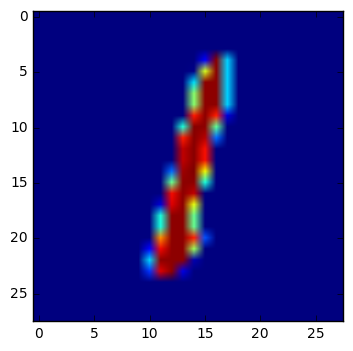

In [5]:
import matplotlib.pyplot as plt
x = X_train[1]
x = np.reshape(x, [28, 28])
print(x.shape)
plt.imshow(x)
plt.show()
%matplotlib inline

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.
import os
import sys
import numpy as np
import scipy.io as sio
from six.moves import cPickle as pickle
from PIL import Image
import tensorflow as tf

data_file = 'pickles/svhn.pickle' 
print 'Tring to load pickle from %s' % data_file
with open(data_file, 'rb') as file:
    svhn_datasets = pickle.load(file)
    train_dataset = svhn_datasets['train_dataset']
    test_dataset = svhn_datasets['test_dataset']
    del svhn_datasets 
print 'pickle loaded successfully!'




Tring to load pickle from pickles/svhn.pickle
pickle loaded successfully!


In [2]:
train_data = train_dataset['X']
train_labels = train_dataset['y']

test_data = test_dataset['X']
test_labels = test_dataset['y']

del train_dataset, test_dataset

print 'Test data:', test_data.shape,', Test labels:', test_labels.shape

Test data: (26032, 32, 32, 3) , Test labels: (26032, 10)


In [3]:
import scipy as si

def resizer(x):
    maxsize = (28, 28)
    x = si.misc.imresize(x, maxsize, interp = 'bilinear')
    return x    
i = 0
X_train = np.zeros((np.shape(train_data)[0], 28, 28, 3))
for row in train_data:
    X_train[i] = resizer(row)
    i+=1
print("New Train set size", X_train.shape)
X_test = np.zeros((np.shape(test_data)[0], 28, 28, 3))
i = 0
for row in test_data:
    X_test[i] = resizer(row)
    i+=1
print("New test set size", X_test.shape)

del train_data
del test_data

('New Train set size', (73257, 28, 28, 3))
('New test set size', (26032, 28, 28, 3))


In [4]:
new_X_train = X_train[10000:]
new_X_train = np.reshape(new_X_train, [-1, 28, 28, 3])
X_test = X_test
X_test = np.reshape(X_test, [-1, 28, 28, 3])
X_valid = X_train[:10000]
X_valid = np.reshape(X_valid, [-1, 28, 28, 3])
y_train = train_labels[10000:]
y_valid = train_labels[:10000]
y_test = test_labels
print('Training set', new_X_train.shape)
print('Training label', y_train.shape)
print('Validation set', X_valid.shape)
print('Validation label', y_valid.shape)
print('Test set', X_test.shape)
print('Test label', y_test.shape)

('Training set', (63257, 28, 28, 3))
('Training label', (63257, 10))
('Validation set', (10000, 28, 28, 3))
('Validation label', (10000, 10))
('Test set', (26032, 28, 28, 3))
('Test label', (26032, 10))


In [5]:
image_size = 28
num_labels = 10
num_channels = 3

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [6]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1], padding='SAME')

with graph.as_default():
    
    train_set = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    valid_set = tf.constant(X_valid)
    test_set = tf.constant(X_test)
    
    keep_prob = tf.placeholder(tf.float32)
    
    W_conv1 = weight_variable(
      [patch_size, patch_size, num_channels, depth])
    b_conv1 = bias_variable([depth])
    W_conv2 = weight_variable(
      [patch_size, patch_size, depth, depth])
    b_conv2 = bias_variable([depth])
    W_conv3 = weight_variable(
      [image_size // 4 * image_size // 4 * depth, num_hidden])
    b_conv3 = bias_variable([num_hidden])
    W_conv4 = weight_variable(
      [num_hidden, num_labels])
    b_conv4 = bias_variable([num_labels])
    
    def model(data):
        data = tf.cast(data, tf.float32)
        conv = conv2d(data, W_conv1)
        pool = max_pool_2x2(conv)
        hidden = tf.nn.relu(pool + b_conv1)
        conv = conv2d(hidden, W_conv2)
        pool = max_pool_2x2(conv)
        hidden = tf.nn.relu(pool + b_conv2)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, W_conv3) + b_conv3)
        drop = tf.nn.dropout(hidden, keep_prob)
        return tf.matmul(drop, W_conv4) + b_conv4

        


    logits = model(train_set)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, train_labels))
    
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(valid_set))
    test_prediction = tf.nn.softmax(model(test_set))

In [ ]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (y_train.shape[0] - batch_size)
    batch_data = X_train[offset:(offset + batch_size), :, :, :]
    batch_labels = y_train[offset:(offset + batch_size), :]
    feed_dict = {train_set : batch_data, train_labels : batch_labels, keep_prob: 1.0}
    feed_dict_w_drop = {train_set : batch_data, train_labels : batch_labels, keep_prob: 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict_w_drop)
    if (step % 100 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(feed_dict=feed_dict), y_valid))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(feed_dict=feed_dict), y_test))
        

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 496.205444
Minibatch accuracy: 0.0%


### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.

from PIL import Image, ImageFilter

def imageprepare(argv):
  """
  This function returns the pixel values.
  The imput is a png file location.
  """
  im = Image.open(argv).convert('L')
  width = float(im.size[0])
  height = float(im.size[1])
  newImage = Image.new('L', (28, 28), (255)) 
  
  if width > height: 
    nheight = int(round((20.0/width*height),0)) 
    if (nheigth == 0): 
      nheigth = 1  
    img = im.resize((20,nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
    wtop = int(round(((28 - nheight)/2),0)) 
    newImage.paste(img, (4, wtop)) 
  else: 
    nwidth = int(round((20.0/height*width),0)) 
    if (nwidth == 0): 
      nwidth = 1
    img = im.resize((nwidth,20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
    wleft = int(round(((28 - nwidth)/2),0)) 
    newImage.paste(img, (wleft, 4)) 

  tv = list(newImage.getdata()) 
  tva = [ (255-x)*1.0/255.0 for x in tv] 
  return tva

In [ ]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

#data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

sess = tf.InteractiveSession()

#model
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x, W) + b)

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)


def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

#loss and optimizer
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess.run(tf.initialize_all_variables())

#training
for i in range(500):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
imvalue = imageprepare('5.png')
prediction=tf.argmax(y_conv,1)
print "predictions", prediction.eval(feed_dict={x: [imvalue],keep_prob: 1.0}, session=sess)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 0, training accuracy 0.1


In [1]:
imvalue = imageprepare('6.png')
prediction=tf.argmax(y_conv,1)
print "predictions", prediction.eval(feed_dict={x: [imvalue],keep_prob: 1.0}, session=sess)

NameError: name 'imageprepare' is not defined

In [ ]:
imvalue = imageprepare('7.png')
prediction=tf.argmax(y_conv,7)
print "predictions", prediction.eval(feed_dict={x: [imvalue],keep_prob: 1.0}, session=sess)

In [ ]:
imvalue = imageprepare('6.png')
prediction=tf.argmax(y_conv,1)
print "predictions", prediction.eval(feed_dict={x: [imvalue],keep_prob: 1.0}, session=sess)

In [ ]:
imvalue = imageprepare('2.png')
prediction=tf.argmax(y_conv,1)
print "predictions", prediction.eval(feed_dict={x: [imvalue],keep_prob: 1.0}, session=sess)

In [ ]:
imvalue = imageprepare('4.png')
prediction=tf.argmax(y_conv,1)
print "predictions", prediction.eval(feed_dict={x: [imvalue],keep_prob: 1.0}, session=sess)

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.